# KMP Algorithm Performance Analysis

This notebook analyzes the `benchmark_results.json` file for the Knuth-Morris-Pratt (KMP) algorithm.

It includes:
1. **Live Comparisons**: KMP vs. Python's `re` module (Time & Memory).
2. **Scalability Analysis**: Time vs. Text Length ($n$) and Pattern Length ($m$).
3. **Real Data Analysis**: Performance on biological genome sequences.


In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import re
import random
import tracemalloc

# --- Configuration ---
JSON_FILE = "benchmark_results.json"
OUTPUT_DIR = "graphs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
sns.set_theme(style="whitegrid")

# --- Load Data Safely ---
if not os.path.exists(JSON_FILE):
    print(f"WARNING: {JSON_FILE} not found.")
    data = {"benchmarks": []}
else:
    with open(JSON_FILE, 'r') as f:
        data = json.load(f)
    print(f"Loaded data from {JSON_FILE}")

Loaded data from benchmark_results.json


## Phase 1: Live KMP vs Regex Comparison
Running a live benchmark to compare Python implementation against C-optimized Regex.

Running live benchmark...


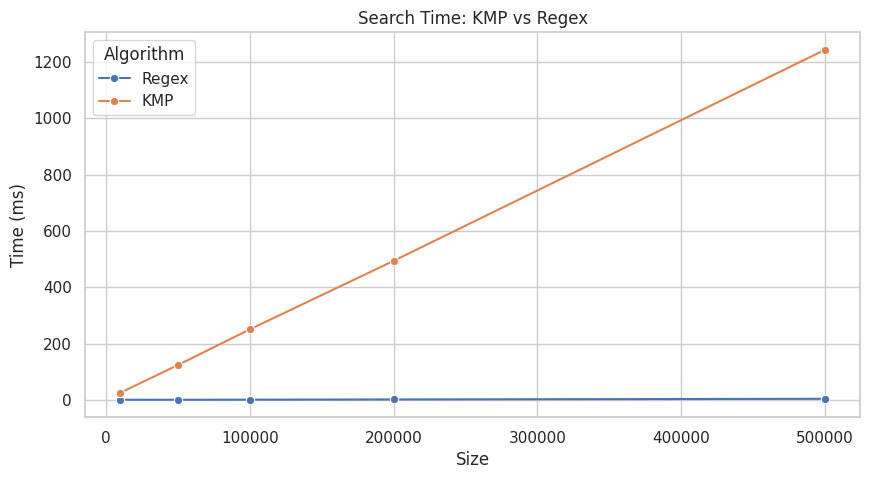

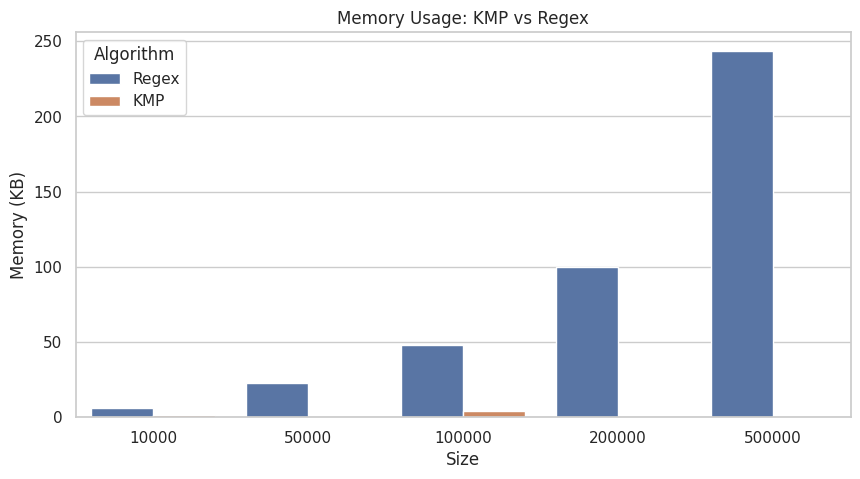

In [2]:
# Try to import your local KMP implementation
try:
    import kmp
    # Find the search function dynamically
    kmp_func = next((getattr(kmp, n) for n in dir(kmp) if 'search' in n.lower() and callable(getattr(kmp, n))), None)
    if not kmp_func: print("Warning: Could not find KMP search function.")
except ImportError:
    kmp_func = None
    print("Warning: kmp.py not found. Live benchmarks will run without it.")

def run_live_comparison():
    results = []
    sizes = [10000, 50000, 100000, 200000, 500000]
    pattern = "ACGT"
    
    print("Running live benchmark...")
    for n in sizes:
        text = ''.join(random.choices('ACGT', k=n))
        
        # Regex Benchmark
        tracemalloc.start()
        start = time.perf_counter()
        list(re.finditer(pattern, text))
        dur = (time.perf_counter() - start) * 1000
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        results.append({"Algorithm": "Regex", "Size": n, "Time (ms)": dur, "Memory (KB)": peak/1024})
        
        # KMP Benchmark (if available)
        if kmp_func:
            tracemalloc.start()
            start = time.perf_counter()
            kmp_func(pattern, text)
            dur = (time.perf_counter() - start) * 1000
            _, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            results.append({"Algorithm": "KMP", "Size": n, "Time (ms)": dur, "Memory (KB)": peak/1024})
            
    return pd.DataFrame(results)

df_live = run_live_comparison()
if not df_live.empty:
    # Plot Time
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_live, x="Size", y="Time (ms)", hue="Algorithm", marker="o")
    plt.title("Search Time: KMP vs Regex")
    plt.savefig(f"{OUTPUT_DIR}/live_time_comparison.png")
    plt.show()
    
    # Plot Memory
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_live, x="Size", y="Memory (KB)", hue="Algorithm")
    plt.title("Memory Usage: KMP vs Regex")
    plt.savefig(f"{OUTPUT_DIR}/live_memory_comparison.png")
    plt.show()

## Phase 2: JSON Benchmark Analysis
Parsing the `benchmark_results.json` file for Pattern Length and Real Data tests.

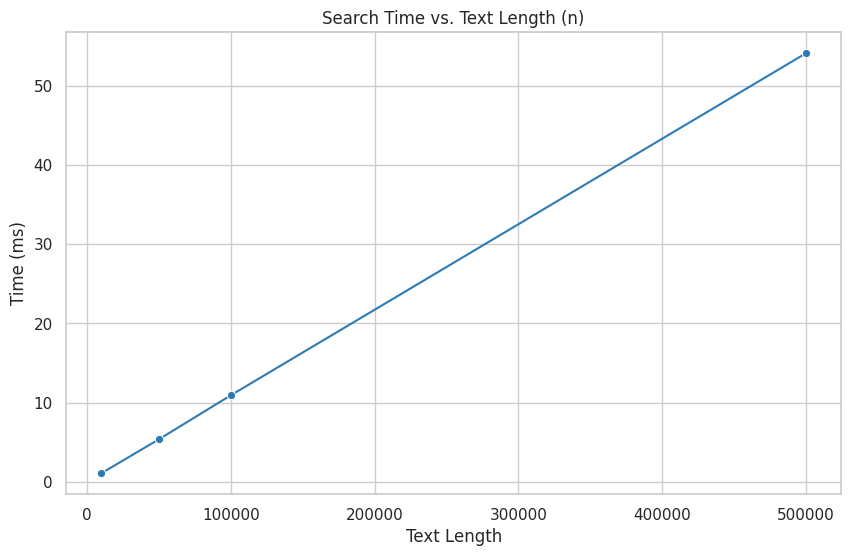

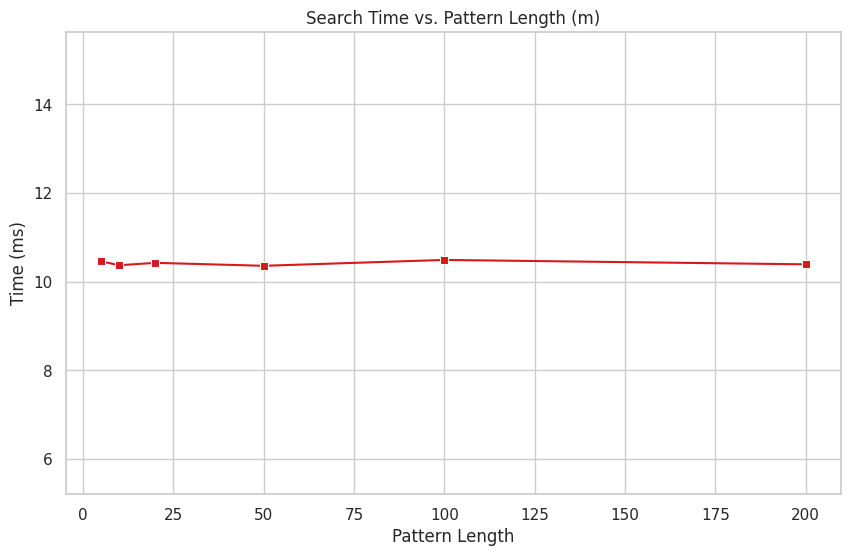

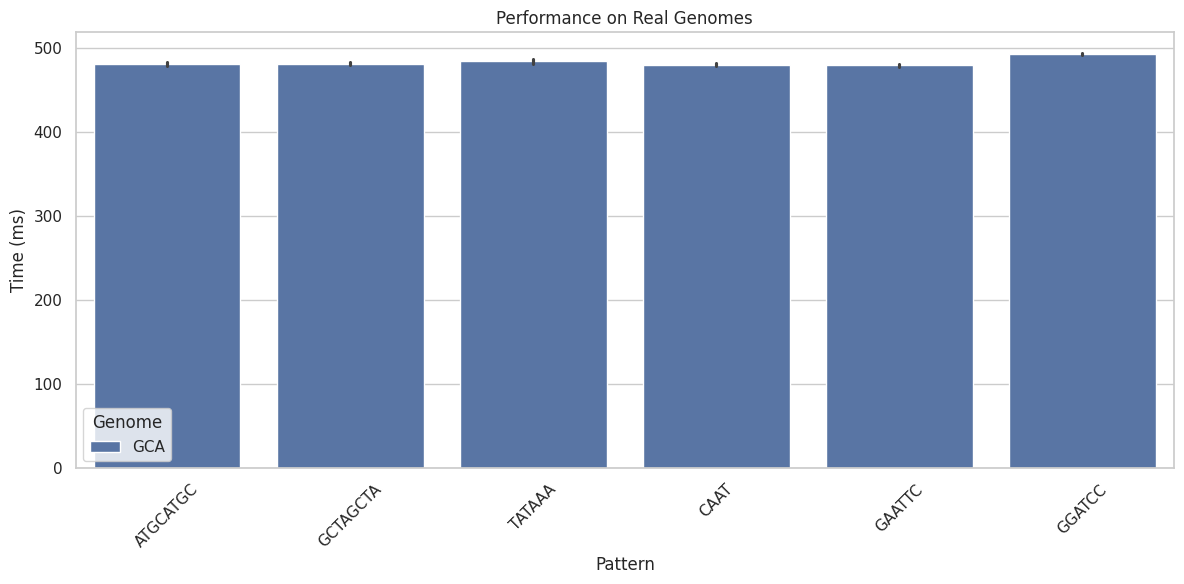

In [3]:
# --- FIX: Use .get() to safely check for 'benchmark_type' ---
benchmarks = data.get('benchmarks', [])

# 1. Text Length Scaling
text_res = [b for b in benchmarks if b.get('benchmark_type') == 'text_length']
if text_res:
    df_text = pd.DataFrame(text_res[0]['results'])
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_text, x="text_length", y="time_ms", marker="o", color="#2c7bb6")
    plt.title("Search Time vs. Text Length (n)")
    plt.xlabel("Text Length")
    plt.ylabel("Time (ms)")
    plt.savefig(f"{OUTPUT_DIR}/json_time_vs_text.png")
    plt.show()

# 2. Pattern Length Scaling
pat_res = [b for b in benchmarks if b.get('benchmark_type') == 'pattern_length']
if pat_res:
    df_pat = pd.DataFrame(pat_res[0]['results'])
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_pat, x="pattern_length", y="time_ms", marker="s", color="#d7191c")
    plt.title("Search Time vs. Pattern Length (m)")
    plt.xlabel("Pattern Length")
    plt.ylabel("Time (ms)")
    # Zoom in to show stability
    mean_y = df_pat['time_ms'].mean()
    plt.ylim(mean_y * 0.5, mean_y * 1.5)
    plt.savefig(f"{OUTPUT_DIR}/json_time_vs_pattern.png")
    plt.show()

# 3. Real Dataset
real_res = [b for b in benchmarks if b.get('benchmark_type') == 'real_dataset']
if real_res:
    rows = []
    for file_res in real_res[0]['results']:
        fname = file_res['filename'].split('_')[0] # Shorten name
        for pat in file_res['patterns']:
            rows.append({
                "Genome": fname,
                "Pattern": pat['pattern'],
                "Time (ms)": pat['time_ms']
            })
    df_real = pd.DataFrame(rows)
    if not df_real.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df_real, x="Pattern", y="Time (ms)", hue="Genome")
        plt.title("Performance on Real Genomes")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/json_real_genomes.png")
        plt.show()